In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [2]:
df = pd.read_csv("../Datasets/8-fraud_detection.csv")
df

,transaction_amount,transaction_risk_score,is_fraud
0,1.879910,-1.485035,0
1,0.377083,-2.238585,0
2,1.354312,-2.664638,0
3,-0.509843,-1.502950,0
4,0.863561,-1.906364,0
...,...,...,...
9995,1.066698,-0.548159,0
9996,1.058723,-0.933768,0
9997,0.995099,-0.541924,0
9998,1.758594,-1.549612,0


In [3]:
X = df.drop("is_fraud",axis=1)
y = df["is_fraud"]

*IMBALANCED DATASETS*

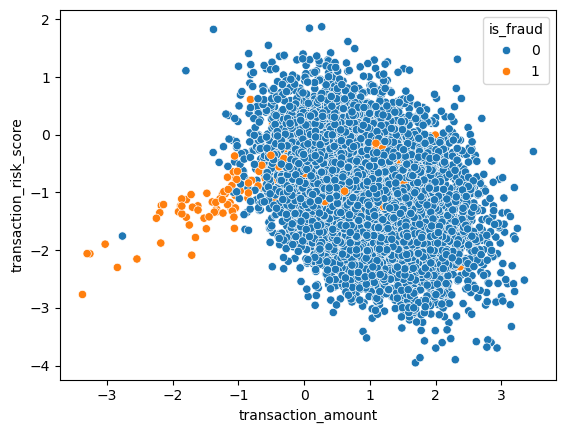

In [18]:
sns.scatterplot(x=X["transaction_amount"],y=X["transaction_risk_score"],hue=y)
plt.show()

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=15)

In [5]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

In [7]:
penalty = ["l1","l2","elasticnet"]
c_values = [100,10,1,0.1,0.01]
solver = ["newton-cg","lbfgs","liblinear","sag","saga","newton-cholesky"]
class_weight = [{0:w,1:y} for w in [1,10,50,100] for y in [1,10,50,100]]
class_weight

[{0: 1, 1: 1},
 {0: 1, 1: 10},
 {0: 1, 1: 50},
 {0: 1, 1: 100},
 {0: 10, 1: 1},
 {0: 10, 1: 10},
 {0: 10, 1: 50},
 {0: 10, 1: 100},
 {0: 50, 1: 1},
 {0: 50, 1: 10},
 {0: 50, 1: 50},
 {0: 50, 1: 100},
 {0: 100, 1: 1},
 {0: 100, 1: 10},
 {0: 100, 1: 50},
 {0: 100, 1: 100}]

In [8]:
params = dict(penalty = penalty,C=c_values,solver=solver,class_weight = class_weight)

In [9]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold
cv = StratifiedKFold()
grid = GridSearchCV(estimator=model,param_grid=params,scoring="accuracy",cv=cv)

In [10]:
import warnings
warnings.filterwarnings("ignore")
grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': [100, 10, 1, 0.1, 0.01],
                         'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 10},
                                          {0: 1, 1: 50}, {0: 1, 1: 100},
                                          {0: 10, 1: 1}, {0: 10, 1: 10},
                                          {0: 10, 1: 50}, {0: 10, 1: 100},
                                          {0: 50, 1: 1}, {0: 50, 1: 10},
                                          {0: 50, 1: 50}, {0: 50, 1: 100},
                                          {0: 100, 1: 1}, {0: 100, 1: 10},
                                          {0: 100, 1: 50}, {0: 100, 1: 100}],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga', 'newton-cholesky']},
             scoring='accuracy')

In [14]:
y_preds = grid.predict(X_test)

In [15]:
y_preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [17]:
score = accuracy_score(y_preds,y_test)
print(f"Accuracy : {score}")
print(classification_report(y_preds,y_test))
print(f"Confusion MAtrix: \n{confusion_matrix(y_preds,y_test)}")

Accuracy : 0.99
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2481
           1       0.42      0.84      0.56        19

    accuracy                           0.99      2500
   macro avg       0.71      0.92      0.78      2500
weighted avg       0.99      0.99      0.99      2500

Confusion MAtrix: 
[[2459   22]
 [   3   16]]


In [31]:
model_prob = grid.predict_proba(X_test)
model_prob

array([[0.99586436, 0.00413564],
       [0.85287009, 0.14712991],
       [0.952308  , 0.047692  ],
       ...,
       [0.98898975, 0.01101025],
       [0.98454137, 0.01545863],
       [0.99758734, 0.00241266]])

In [32]:
model_prob = model_prob[:,1] # probablities for the positive fraud class
model_prob

array([0.00413564, 0.14712991, 0.047692  , ..., 0.01101025, 0.01545863,
       0.00241266])

In [33]:
from sklearn.metrics import roc_curve,roc_auc_score
model_auc = roc_auc_score(y_test,model_prob)
model_auc

0.7392898371029116

In [35]:
# model false positive rate
# model true positive rate
model_fpr,model_tpr,thresholds = roc_curve(y_test,model_prob)

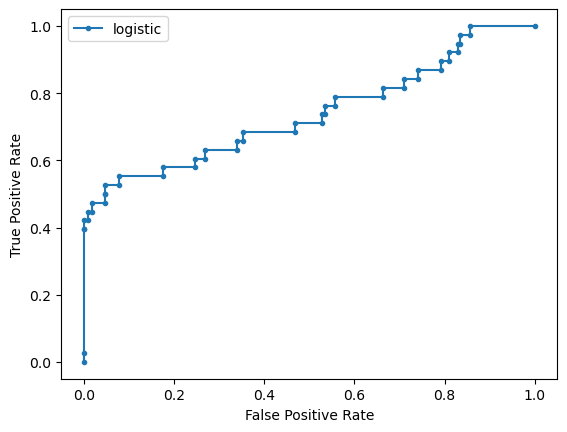

In [36]:
plt.plot(model_fpr,model_tpr,marker=".",label="logistic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

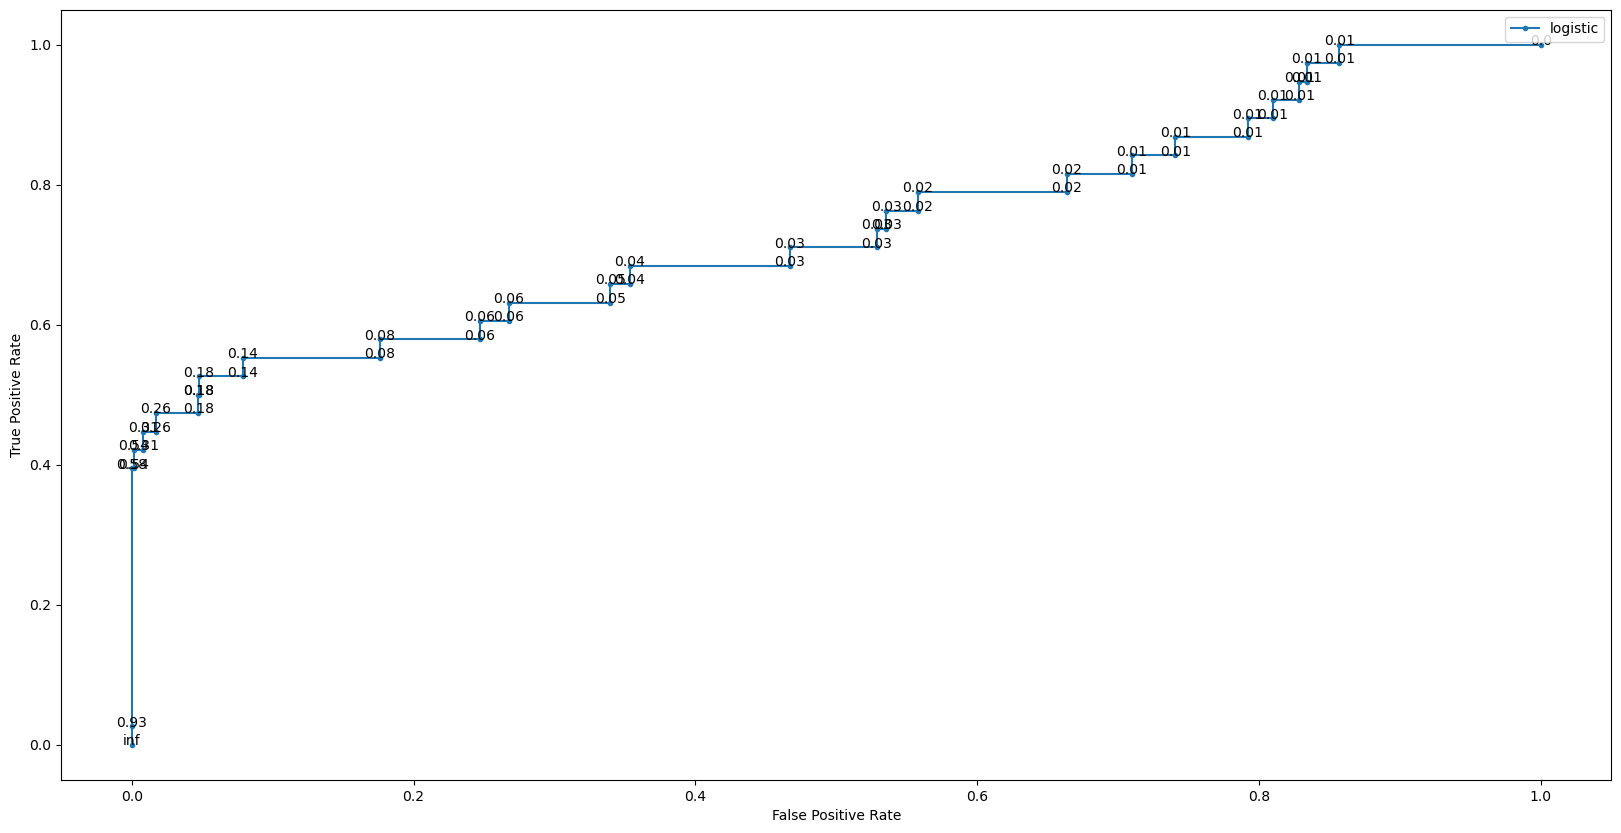

In [37]:
fig ,ax = plt.subplots(figsize=(20,10))
ax.plot(model_fpr,model_tpr,marker=".",label="logistic")
for fpr,tpr,thresh in zip(model_fpr,model_tpr,thresholds):
    ax.annotate(f"{np.round(thresh,2)}",(fpr,tpr),ha="center")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
plt.legend()
plt.show()

In [40]:
custom_threshold = 0.5
y_pred_custom = (model_prob>=custom_threshold).astype(int)
y_pred_custom

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
print(confusion_matrix(y_pred_custom,y_test))
print(classification_report(y_pred_custom,y_test))

[[2459   22]
 [   3   16]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2481
           1       0.42      0.84      0.56        19

    accuracy                           0.99      2500
   macro avg       0.71      0.92      0.78      2500
weighted avg       0.99      0.99      0.99      2500

